In [47]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns

### Example Data ###

We assume 5 income classes with a left-skewed multinomial distribution. Income is to be considered as the after taxes monthly salary.

In [16]:
inc_classes = ["500 - 1500", "1501 - 2500", "2501 - 3500", "3501 - 5500", "5501 - 7500"]
frequencies = [0.1, 0.4, 0.3, 0.15, 0.05]  # Example frequencies for each bin

data = pd.DataFrame(
    {
        "income_class": inc_classes,
        "frequency": frequencies
    }
)

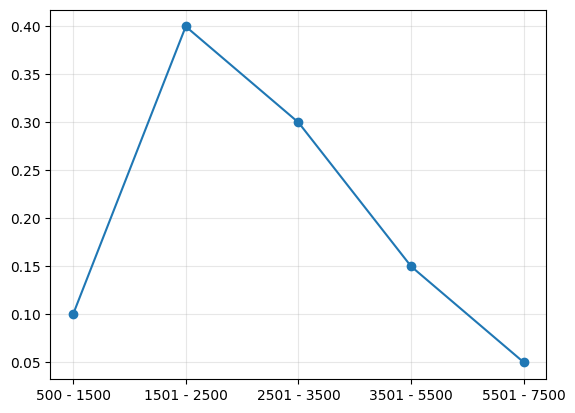

In [ ]:
_ = plt.plot(data["income_class"], data["frequency"], marker="o")
_ = plt.grid(alpha=.3)

### Individual Incomes Distribution ###

Here we sample the individual income using a two step process: first, we sample the income class using a multinomial distribution and then, for each class, we sample from a gaussian distribution centered at the middle value of the income class and with a standard deviation proportional to the width of the class. We could also use a uniform distribution for each class of income. Also, we could consider using a Patero for the upper classes.

The result is a left skewed distribution, resembling the real income one.

Gathering real income micro-data would result in a much realistic distribution here, but for now we keep it simple and just simulate them.

In [ ]:
def sample_from_class(lower, upper, n_samples=1, std_fraction=6, distrib: str = "normal"):
    """
    Samples values from a truncated Gaussian distribution within given limits.
    
    Parameters:
        lower (float): Lower boundary of the income class
        upper (float): Upper boundary of the income class
        n_samples (int): Number of samples to draw
        std_fraction (float): Denominator to set standard deviation (spread) dynamically
        
    Returns:
        np.array: Samples from truncated Gaussian distribution
    """
    if distrib not in ["normal", "uniform"]:
        raise ValueError(
            "distrib should be one of ('normal', 'uniform')"
        )
    if distrib == "normal":
        midpoint = (lower + upper) / 2
        std = (upper - lower) / std_fraction  # Spread of the Gaussian; adjustable
        
        # Define the truncated Gaussian parameters
        a, b = (lower - midpoint) / std, (upper - midpoint) / std  # Truncation in std units
        samples = truncnorm.rvs(a, b, loc=midpoint, scale=std, size=n_samples)

    else:
        samples = np.random.uniform(lower, upper, size=n_samples)
    
    return samples


def sample_income_class(income_data: pd.DataFrame) -> str:
    income_distrib = pd.DataFrame(
        {
            "income": income_data["income_class"],
            "sample": np.random.multinomial(1, income_data["frequency"].tolist())
        }
    )
    return income_distrib.query("sample == 1")["income"].tolist()[0]


def get_truncation_for_gaussian(income_class: str) -> List[int]:
    truncs = income_class.split(" - ")
    return [int(trunc) for trunc in truncs]


def sample_individual_income(
    income_data: pd.DataFrame, 
    std_fraction: int | float = 2.0,
    distrib: str = "normal"
) -> float:
    income_class = sample_income_class(income_data)
    truncations = get_truncation_for_gaussian(income_class)
    return sample_from_class(
        truncations[0], 
        truncations[1], 
        std_fraction=std_fraction,
        distrib=distrib
    )[0]

inc_samples = [sample_individual_income(data) for _ in range(5000)]

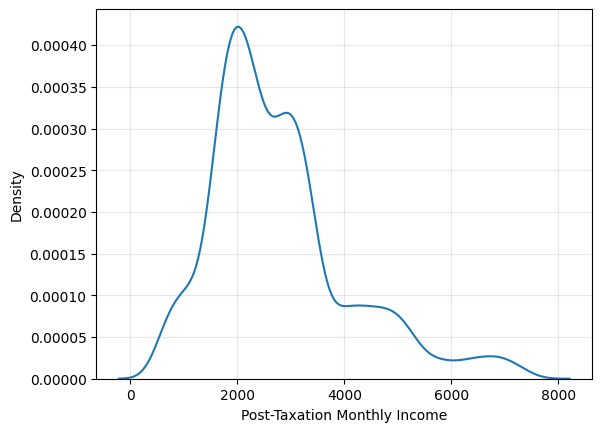

In [105]:
_ = sns.kdeplot(inc_samples)
_ = plt.grid(alpha=.3)
_ = plt.xlabel("Post-Taxation Monthly Income")

The smoothness of the distribution is proportional to the number of income class that we choose.

**NB**: the Kernel Density Estimation interpolates values also for 0 and 8000, even though they are not considered in the income classes.

### The Progressive Consumption Tax ###

We use a continuous function to assign the consumption tax to each individual income. For a matter of semplicity, we assume a constant baseline consumption tax of 0.22 (22%).

Here, we propose a scaled logistic function based tax. A scaled logistic function has some interesting properties that make it a good candidate for simulating a progressive tax:
- First, the scaling procedure allows to consider a lower and an upper limit.
- It naturally maps data from the R line to [0, 1].
- Maximum and minimum values can be selected.
- The steepness factor allows to consider different levels of progressivity.

In [95]:
def scaled_sigmoid(x, a, b, x_min, x_max, k=0.001):
    x_mid = (x_min + x_max) / 2
    return a + (b - a) / (1 + np.exp(-k * (x - x_mid)))


a, b, k = 0.15, 0.35, 0.001
cons_tax = scaled_sigmoid(sorted(inc_samples), a, b, min(inc_samples), max(inc_samples), k=k)

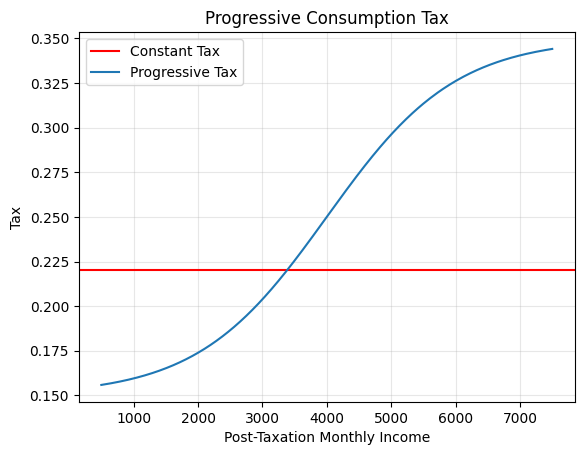

In [102]:
plt.axhline(.22, color="r", label="Constant Tax")
plt.plot(sorted(inc_samples), cons_tax, label="Progressive Tax")
plt.title("Progressive Consumption Tax")
plt.xlabel("Post-Taxation Monthly Income")
plt.ylabel("Tax")
plt.legend()
plt.grid(alpha=.3)
plt.show()